In [1]:
import pandas as pd
import geopandas as gpd
from IPython.display import clear_output
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from ema_workbench import load_results

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance_matrix

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import numpy as np

import clustering_helper as ch

clear_output()

In [2]:
results = load_results('sim_results.tar.gz') #load EMA workbench results
experiments, outcomes = results #differentiate input space (experiments) and output space (outcomes)

outcomes_df = pd.DataFrame(outcomes)
experiments_df = pd.DataFrame(experiments)

results_df = outcomes_df.join(experiments_df)
results_df = results_df[results_df.columns[23:46]]

## Preprocess data

In [3]:
results_standardized = results_df.copy()

for i in range(len(results_standardized)):
    results_standardized.iloc[i] = [x[0] for x in StandardScaler().\
                                    fit_transform(results_standardized.iloc[i].values.reshape(-1, 1))]

In [4]:
'''
############## Uncertainties list ##############
clim_scen = future hydrographs. 1: rcp4.5, 2: rcp8.5, val:historical
lud_scen = land-use demand scenario. 1: BAU, 2: shift back to 2-rice, 3: heavy urbanization, 4: rising non-rice
TE = trapping efficiency of upstream dam, for dam scenarios, 1: no dam construction, 5: many dam constructions (95% TE)
yield_adjust_SA_scaling = scaling factor for Summer-Autumn crop yield reduction, default=1
yield_adjust_AW_scaling = scaling factor for Autumn-Winter crop yield reduction, default=1

############## Policies list ##############
pol_dike_switch_dt = 0: use dike map of 2011 for Dong Thap, 1: all high dikes after 2020, 2: all low dikes after 2020
pol_dike_switch_ag = 0: use dike map of 2011 for An Giang, 1: all high dikes after 2020, 2: all low dikes after 2020
pol_fer = 0: no policy, default pol_fer, 3: 50kg to districts far from river
pol_seed = 0: no policy, 1: upgrade seed variety so more resitant to flooding

'''
clear_output()

In [5]:
#one-hot encoder for lud_scen
for scen in np.unique(experiments_df['lud_scen']):
    experiments_df['lud_scen_{}'.format(scen)] = experiments_df['lud_scen']==scen
    experiments_df['lud_scen_{}'.format(scen)] = experiments_df['lud_scen_{}'.format(scen)].astype(int)    
del experiments_df['lud_scen']

#one-hot encoder for pol_dike_switch_ag
for scen in np.unique(experiments_df['pol_dike_switch_ag']):
    if scen > 0:
        experiments_df['pol_dike_switch_ag_{}'.format(scen)] = experiments_df['pol_dike_switch_ag']==scen
        experiments_df['pol_dike_switch_ag_{}'.format(scen)] = experiments_df['pol_dike_switch_ag_{}'.format(scen)].astype(int)    
del experiments_df['pol_dike_switch_ag']

#one-hot encoder for pol_dike_switch_dt
for scen in np.unique(experiments_df['pol_dike_switch_dt']):
    if scen > 0:
        experiments_df['pol_dike_switch_dt_{}'.format(scen)] = experiments_df['pol_dike_switch_dt']==scen
        experiments_df['pol_dike_switch_dt_{}'.format(scen)] = experiments_df['pol_dike_switch_dt_{}'.format(scen)].astype(int)    
del experiments_df['pol_dike_switch_dt']

#one-hot encoder for pol_fer
experiments_df['pol_fer'] /= 3

In [6]:
#delete unused columns
del experiments_df['model']
del experiments_df['policy']

## Look for best clustering algorithm

In [14]:
X = results_standardized.copy()
n_cluster=20
EV_dict, EV_increase_dict = ch.evaluate_explained_variance(n_cluster, X)

start GMM
012345678910111213141516171819start kmedoids
012345678910111213141516171819start kmeans
012345678910111213141516171819start agg-average
012345678910111213141516171819start agg-complete
012345678910111213141516171819

GMM 0.15539064823598137 3
kmedoids 0.6927913784854451 7
kmeans 0.7104908787450643 7
agg-average 0.6243368032146239 6
agg-complete 0.6184976276909587 7


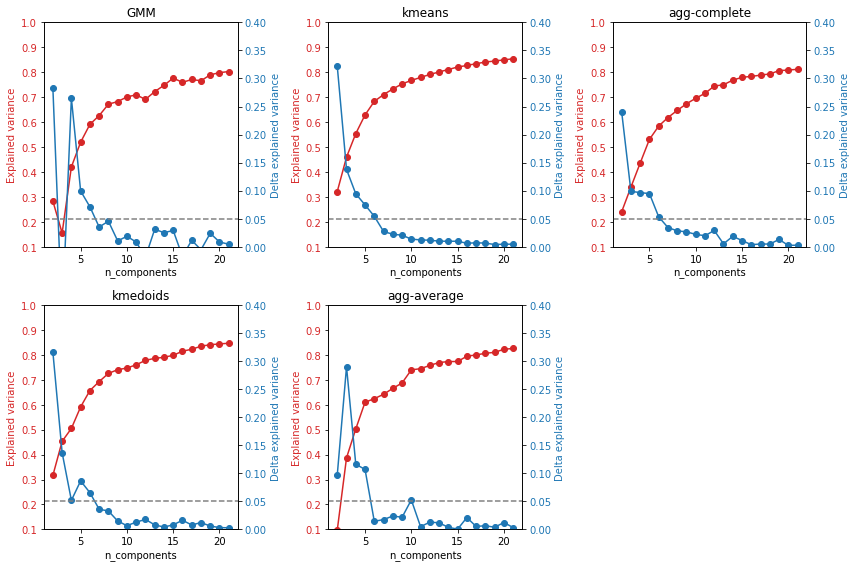

In [17]:
ch.plot_explained_variance(EV_dict, EV_increase_dict)

In [22]:
clusterer = KMeans(n_clusters=7, random_state=10)
labels_used = clusterer.fit_predict(X)
experiments_df['label'] = labels_used

In [24]:
np.unique(labels_used,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([7879, 8484, 5323, 2204, 4790, 5776, 8744], dtype=int64))

## Visualization of the clusters

In [30]:
#use medoid of each cluster as representative inequality cluster of that cluster
results_cluster_medoid = pd.DataFrame(columns=results_standardized.columns[:-1])

for c in np.unique(labels_used):
    results_standardized_ = results_standardized.loc[labels_used==c]
    results_standardized_ = results_standardized_[results_standardized_.columns[:23]]
    
    print('Start calculating distance matrix ' + str(c))
    dist_matrix = distance_matrix(results_standardized_, results_standardized_)
    medoid_id = np.argmin(dist_matrix.sum(axis=0))
    
    print(medoid_id)
    
    results_cluster_medoid = results_cluster_medoid.append(results_standardized_.iloc[medoid_id])

Start calculating distance matrix 0
7378
Start calculating distance matrix 1
4606
Start calculating distance matrix 2
1396
Start calculating distance matrix 3
1355
Start calculating distance matrix 4
2684
Start calculating distance matrix 5
737
Start calculating distance matrix 6
4383


In [31]:
dtag_gdf2 = gpd.read_file('DTAG_districts.shp')
dtag_gdf2 = dtag_gdf2.loc[dtag_gdf2['DN']>0]
dtag_gdf2.reset_index(inplace=True)

for cluster in np.unique(labels_used):
    avrg_profit = {}
    
    for col in results_cluster_medoid.columns:
        district_id = int(col.split('_')[1])
        val = results_cluster_medoid.iloc[cluster][col]
        
        avrg_profit[district_id] = val
    
    dtag_gdf2['cluster_'+str(cluster)] = dtag_gdf2['DN'].map(avrg_profit)

In [34]:
#normalize to 0-1
for col in dtag_gdf2.columns[-7:]:
    dtag_gdf2[col] = dtag_gdf2[col] - dtag_gdf2[col].min()
    dtag_gdf2[col] /= dtag_gdf2[col].max()

Text(0.5,1,'Relative\nprofitability')

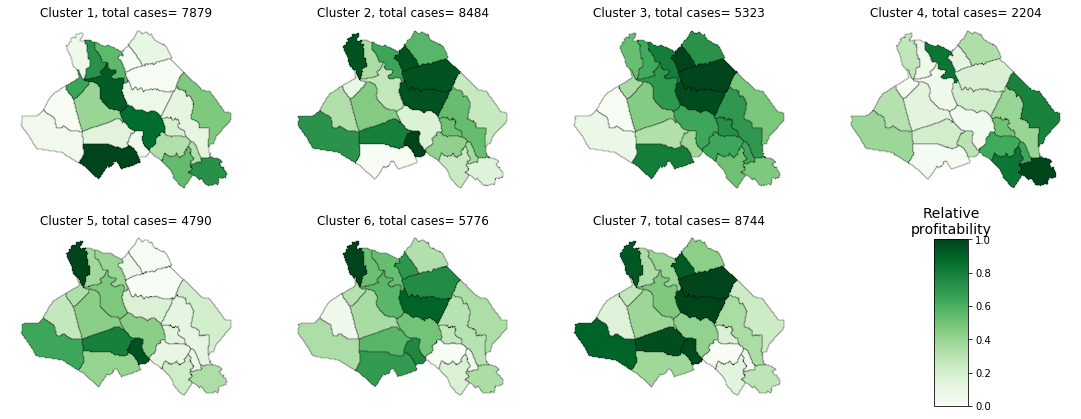

In [36]:
fig, axes = plt.subplots(2, 4, figsize=(19,7))
i,j = 0,0

for c in np.unique(labels_used):
    
    name = 'cluster_' + str(c)
    dtag_gdf2.plot(column=name, legend=False, ax=axes[i,j], cmap='Greens', linewidth=0.3, edgecolor='black')
    axes[i,j].get_xaxis().set_visible(False)
    axes[i,j].get_yaxis().set_visible(False)
    axes[i,j].axis('off')
    totcase = np.unique(labels_used, return_counts=True)[1][c]
    axes[i,j].set_title('Cluster '+str(c+1) + ', total cases= ' + str(totcase))
    
    if j < 3:
        j += 1
    else:
        j = 0
        i += 1

fig.delaxes(axes[-1,-1])

###colorbar legend
sm =  ScalarMappable(cmap='Greens')
sm.set_array([])
cbaxes = fig.add_axes([0.8, 0.12, 0.025, 0.33]) #start x, start y, length x, length y
cbar = fig.colorbar(sm, ax=axes[-1,-1], cax=cbaxes)
cbar.ax.set_title("Relative\nprofitability", fontsize=14)

## GradientBoost classifier

In [37]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from ema_workbench import load_results, ema_logging
from ema_workbench.analysis import feature_scoring

C:\Users\bjafino\anaconda3\envs\py36_dtag01\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.univariate_selection module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [38]:
experiments_df2 = experiments_df
try:
    del experiments_df2['label']
except:
    pass
try:
    del experiments_df2['scenario']
except:
    pass

In [39]:
# transform to numpy array with proper recoding of cateogorical variables
try:
    np.delete(experiments, 'policy')
    np.delete(experiments, 'model')
except:
    pass
x = experiments_df2
y = labels_used

# fit the boosted tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                         algorithm="SAMME",
                         n_estimators=200)
bdt.fit(x, y)

# determine which dimensions are most important
sorted_indices = np.argsort(bdt.feature_importances_)[::-1]

C:\Users\bjafino\anaconda3\envs\py36_dtag01\lib\site-packages\ipykernel\__main__.py:3: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  app.launch_new_instance()


In [42]:
feature_importances = dict(zip(experiments_df.columns, bdt.feature_importances_))
feature_importances

{'TE': 0.26321140119936903,
 'clim_scen': 0.018777268820939243,
 'lud_scen_1.0': 0.014937289481280144,
 'lud_scen_2.0': 0.02000692524250673,
 'lud_scen_3.0': 0.0023599989708199287,
 'lud_scen_4.0': 0.00047435308319518555,
 'pol_dike_switch_ag_1.0': 0.14905390486651365,
 'pol_dike_switch_ag_2.0': 0.1561191215445212,
 'pol_dike_switch_dt_1.0': 0.1367208219034217,
 'pol_dike_switch_dt_2.0': 0.09201198585657007,
 'pol_fer': 0.016472598894580495,
 'pol_seed': 1.7932146179101529e-16,
 'yield_adjust_AW_scaling': 0.11443661723104089,
 'yield_adjust_SA_scaling': 0.015417712905241581}

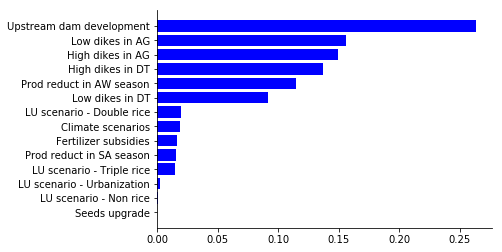

In [43]:
from collections import OrderedDict

feature_name_map = {'TE': 'Upstream dam development',
                    'clim_scen': 'Climate scenarios',
                    'lud_scen_1.0': 'LU scenario - Triple rice',
                    'lud_scen_2.0': 'LU scenario - Double rice',
                    'lud_scen_3.0': 'LU scenario - Urbanization',
                    'lud_scen_4.0': 'LU scenario - Non rice',
                    'pol_dike_switch_ag_1.0': 'High dikes in AG',
                    'pol_dike_switch_ag_2.0': 'Low dikes in AG',
                    'pol_dike_switch_dt_1.0': 'High dikes in DT',
                    'pol_dike_switch_dt_2.0': 'Low dikes in DT',
                    'pol_fer': 'Fertilizer subsidies',
                    'pol_seed': 'Seeds upgrade',
                    'yield_adjust_AW_scaling': 'Prod reduct in AW season',
                    'yield_adjust_SA_scaling': 'Prod reduct in SA season'}

feature_names = [feature_name_map[x] for x in experiments_df.columns]

viz_importances = dict(zip(feature_names, bdt.feature_importances_))
viz_importances = OrderedDict(sorted(viz_importances.items(), key=lambda kv: kv[1], reverse=True))

colors = ['blue']*(len(feature_names)-4) + ['red']*4
colors = 'blue'

fig, ax = plt.subplots()
ax.barh(range(len(viz_importances)), [x for x in reversed(list(viz_importances.values()))], align='center', color=colors)
plt.yticks(range(len(viz_importances)), [x for x in reversed(list(viz_importances.keys()))], rotation=0)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [44]:
y_predict_all = bdt.predict(x)

In [45]:
#take four most important drivers
drivers_to_use = [experiments_df.columns[i] for i in sorted_indices[:4]]
print(drivers_to_use)
print(sum([feature_importances[x] for x in drivers_to_use]))

['TE', 'pol_dike_switch_ag_2.0', 'pol_dike_switch_ag_1.0', 'pol_dike_switch_dt_1.0']
0.7051052495138257


In [47]:
x1 = experiments_df[drivers_to_use]

In [49]:
x1.columns = ['TE', 'ag_2', 'ag_1', 'dt_1']
x1['dike'] = x1['ag_2'] * 1 + x1['ag_1'] * 10 + x1['dt_1'] * 100

dct = {0: 'no dike', 1: 'ag_2', 10: 'ag_1', 100: 'dt_1',
       11: 'ag_1_2', 101: 'ag_2_dt_1', 110: 'ag_1_dt_1', 111: 'ag_1_2_dt_1'}

x1['dike'] = x1['dike'].apply(lambda x: dct[x])
clear_output()

In [51]:
x1_and_y = x1[['TE', 'dike']]
x1_and_y['cluster'] = y
x1_and_y['TE'] = x1_and_y['TE'].astype(int)
clear_output()

In [52]:
x1_and_y_ = x1_and_y.loc[x1_and_y['cluster']==3]
x1_and_y_ = x1_and_y_.pivot_table(values='cluster', index='TE', columns='dike', aggfunc='count', fill_value=0)
for col in np.unique(x1_and_y['dike']):
    if col not in x1_and_y_.columns:
        x1_and_y_[col] = 0
x1_and_y_.fillna(0)
x1_and_y_ = x1_and_y_.reindex(sorted(x1_and_y_.columns), axis=1)

In [54]:
dike_naming_dict = {'ag_1': '1_AG_lo',
                    'ag_1_dt_1': '4_AG_lo+DT_lo',
                    'ag_2': '2_AG_hi',
                    'ag_2_dt_1': '5_AG_hi+DT_lo',
                    'dt_1': '3_DT_lo',
                    'no dike': '0_Current dikes'} #SALAH TOTAL

dike_naming_dict = {'ag_1': '1_AG_hi',
                    'ag_1_dt_1': '4_AG_hi+DT_hi',
                    'ag_2': '2_AG_lo',
                    'ag_2_dt_1': '5_AG_lo+DT_hi',
                    'dt_1': '3_DT_hi',
                    'no dike': '0_Current dikes'}

In [55]:
x1_and_y['dike'] = x1_and_y['dike'].map(dike_naming_dict)

C:\Users\bjafino\anaconda3\envs\py36_dtag01\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


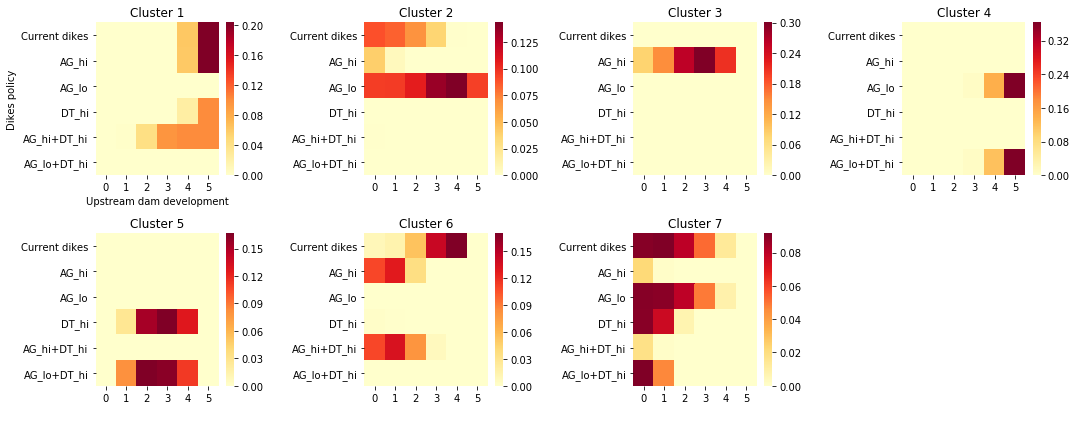

In [56]:
fig, axes = plt.subplots(2,4, figsize=(15,6))

i,j = 0,0

for c in np.unique(y):
    x1_and_y_ = x1_and_y.loc[x1_and_y['cluster']==c]
    x1_and_y_ = x1_and_y_.pivot_table(values='cluster', index='TE', columns='dike', aggfunc='count', fill_value=0)
    for te in np.unique(x1_and_y['TE']):
        try:
            _ = x1_and_y_.loc[te]
        except:
            x1_and_y_.loc[te] = 0
    for col in np.unique(x1_and_y['dike']):
        if col not in x1_and_y_.columns:
            x1_and_y_[col] = 0
    x1_and_y_.fillna(0)
    x1_and_y_ = x1_and_y_.reindex(sorted(x1_and_y_.columns), axis=1)
    x1_and_y_.sort_index(inplace=True)
    
#     axes[j,i].set_title('Cluster ' + str(c+1) + ', total cases = ' + str(x1_and_y_.sum().sum()))
    axes[j,i].set_title('Cluster ' + str(c+1) )
    
    #for normalization
    #if normalized, remove the vmin and vmax or change the vmin and vmax to 0-1 or to 0-0.5
    #x1_and_y_ = (x1_and_y_ - x1_and_y_.min().min()) / (x1_and_y_.max().max() - x1_and_y_.min().min()) #normalize to max case in a cell
    x1_and_y_ /= x1_and_y_.sum().sum() #normalize to total cases
    
    x1_and_y_ = x1_and_y_.T
    x1_and_y_.index = [x[2:] for x in x1_and_y_.index]
    sns.heatmap(x1_and_y_, cmap='YlOrRd', ax=axes[j,i])
    
    if i + j > 0:
        axes[j,i].set_xlabel(' ')
        axes[j,i].set_ylabel(' ')
    else:
        axes[j,i].set_xlabel('Upstream dam development')
        axes[j,i].set_ylabel('Dikes policy')
    
    if i < 3:
        i += 1
    else:
        j += 1
        i = 0
        
axes[-1,-1].axis('off')
plt.tight_layout()